# Titanic Competition

This notebook is a walkthrough of the Titanic competition on Kaggle. The goal of this competition is to predict whether a passenger survived the sinking of the Titanic or not.  
The datasets provided for this competition are split into two files:
- train.csv - the training set
- test.csv - the test set

## Setup

In [36]:
%pip install numpy pandas matplotlib seaborn scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Imports for data analysis and data viz

import numpy as np  # linear algebra
import pandas as pd  # data processing
import matplotlib.pyplot as plt  # data viz
import seaborn as sns  # data viz

In [38]:
# Imports for machine learning

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Basic data exploration

In [39]:
# load training dataset
train_df = pd.read_csv("./data/train.csv")

In [40]:
# load test dataset
test_df = pd.read_csv("./data/test.csv")

In [41]:
# quick look at the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data dictionary is the following:

| Variable | Definition    | Key |
| -------- | ----------    | --- |
| Survival | Survival      | 0 = No, 1 = Yes |
| Pclass   | Ticket class  | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex      | Sex           | male, female |
| Age      | Age in years  | |
| SibSp    | Number of siblings aboard | |
| Parch    | Number of parents aboard | |
| Ticket   | Ticket number  | |
| Fare     | Passenger fare | |
| Cabin    | Cabin number   | |
| Embarked | Port of embarkation | C = Cherbourg, Q = Queenstwon, S = Southampton |



In [42]:
# check the data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [43]:
# check for missing values in the training dataset
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [44]:
# check for missing values in the test dataset
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We can see that the data is divided into two groups:
- Numerical: Age, SibSp, Parch and Fare.
- Categorical: Survived, Pclass, Sex, Ticket, Cabin and Embarked.

Since the Cabin variable has a lot of missing values, we can drop it from the dataset. For the Embarked variable we can simply make an educated guess and fill the missing values with the most common value. And with the Age variable we can fill the missing values with the median age.

From the Ticket variable we could try to extract the ticket prefix and see if it has any correlation with the survival rate but I don't think it will be very useful so it will also be dropped.

## Data cleaning

In [45]:
# drop the Cabin column
train_df = train_df.drop(["Cabin"], axis=1)
test_df = test_df.drop(["Cabin"], axis=1)

In [46]:
# drop the Ticket column
train_df = train_df.drop(["Ticket"], axis=1)
test_df = test_df.drop(["Ticket"], axis=1)

In [47]:
# fill missing values in the Embarked column with the most common value
train_df["Embarked"] = train_df["Embarked"].fillna(
    train_df["Embarked"].value_counts().index[0]
)

test_df["Embarked"] = test_df["Embarked"].fillna(
    test_df["Embarked"].value_counts().index[0]
)

In [48]:
# fill missing values in the Age column with the mean value and a little bit of noise
train_df["Age"] = train_df["Age"].fillna(
    train_df["Age"].mean() + np.random.normal(0, 0.7)
)

test_df["Age"] = test_df["Age"].fillna(test_df["Age"].mean() + np.random.normal(0, 0.7))

In [49]:
# fill missing values in the Fare column with the mean value and a little bit of noise in the test dataset
test_df["Fare"] = test_df["Fare"].fillna(
    test_df["Fare"].mean() + np.random.normal(0, 0.7)
)

In [50]:
# check again the data after the changes
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.732435,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002188,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.866832,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data visualization

In [51]:
# numerical features
num_df = train_df[["Age", "SibSp", "Parch", "Fare"]]
num_df.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [52]:
# categorical features
cat_df = train_df[["Survived", "Pclass", "Sex", "Embarked"]]
cat_df.head()

,Survived,Pclass,Sex,Embarked
0,0,3,male,S
1,1,1,female,C
2,1,3,female,S
3,1,1,female,S
4,0,3,male,S


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

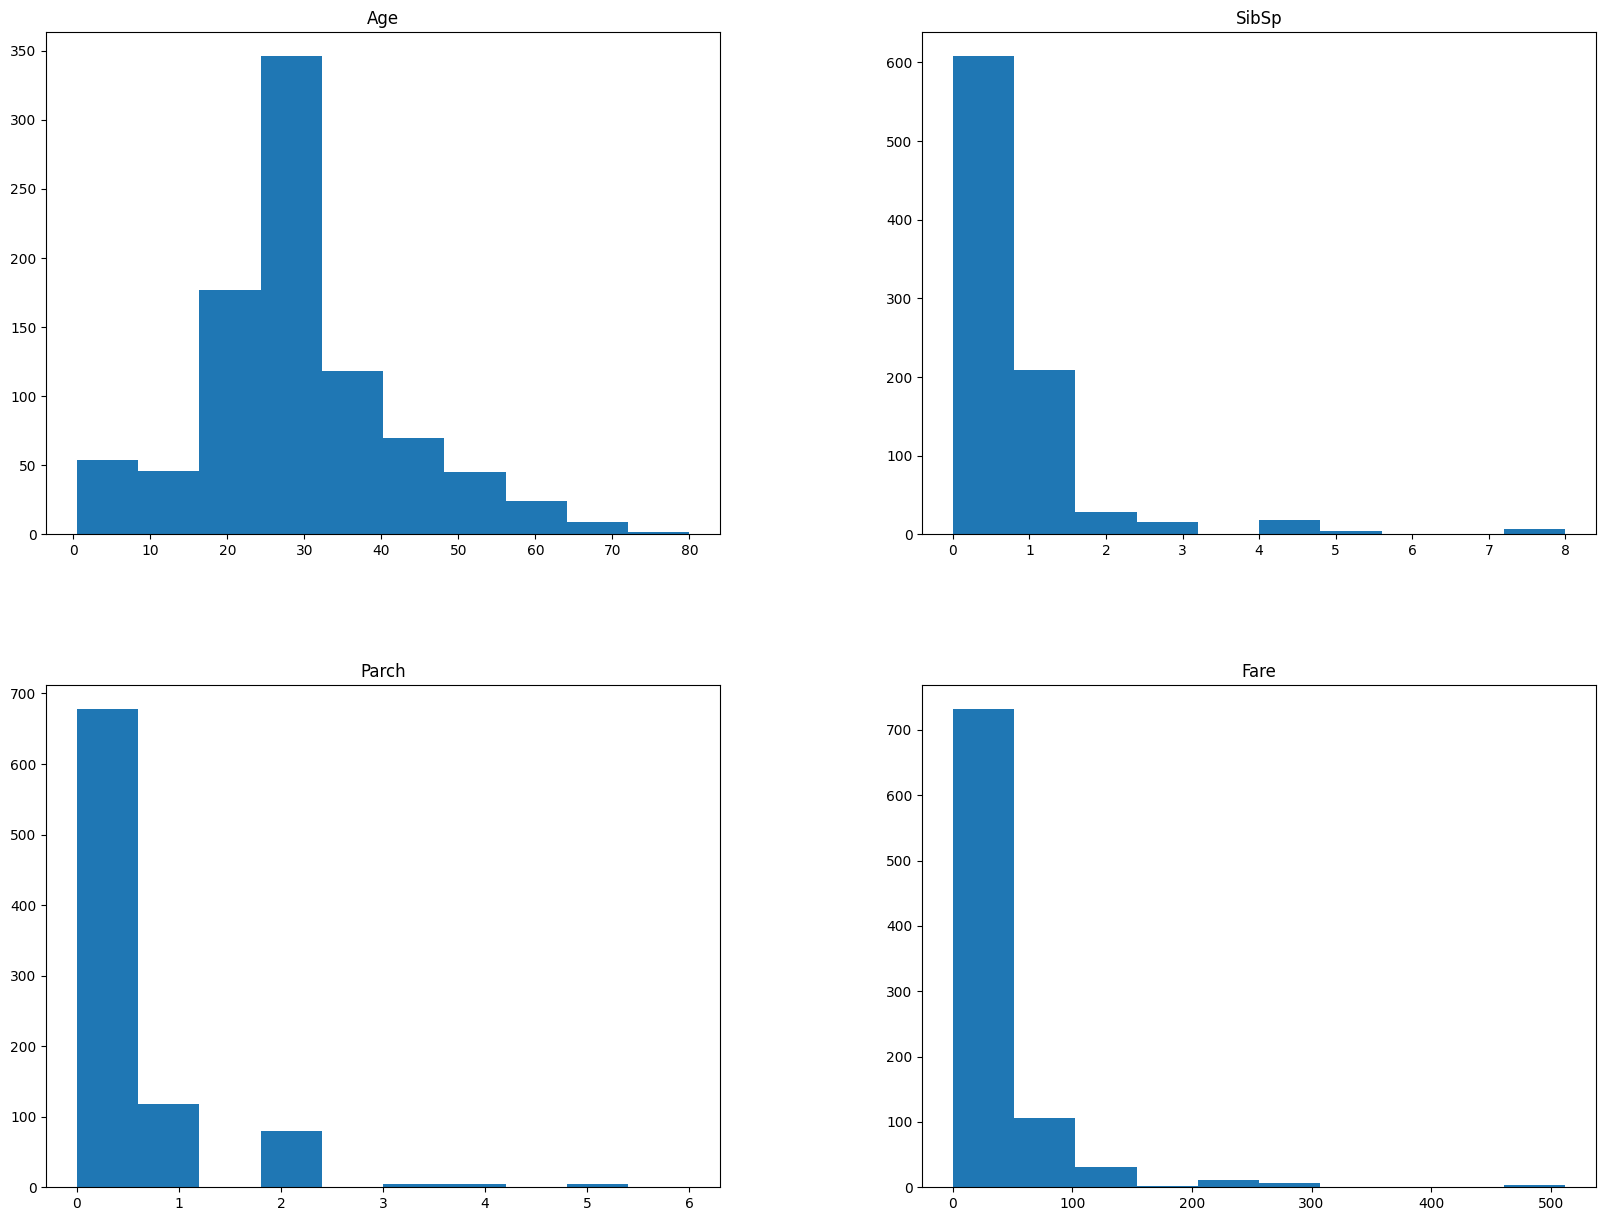

In [53]:
# plot numerical features
num_df.hist(figsize=(20, 15), grid=False)

In [54]:
# add survived column to the numerical features
num_df["Survived"] = train_df["Survived"]

/tmp/ipykernel_12099/3858560246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df["Survived"] = train_df["Survived"]


In [55]:
# create a correlation matrix between the numerical features
corr_matrix = num_df.corr().round(2)
corr_matrix

,Age,SibSp,Parch,Fare,Survived
Age,1.00,-0.23,-0.18,0.09,-0.07
SibSp,-0.23,1.00,0.41,0.16,-0.04
Parch,-0.18,0.41,1.00,0.22,0.08
Fare,0.09,0.16,0.22,1.00,0.26
Survived,-0.07,-0.04,0.08,0.26,1.00


<Axes: >

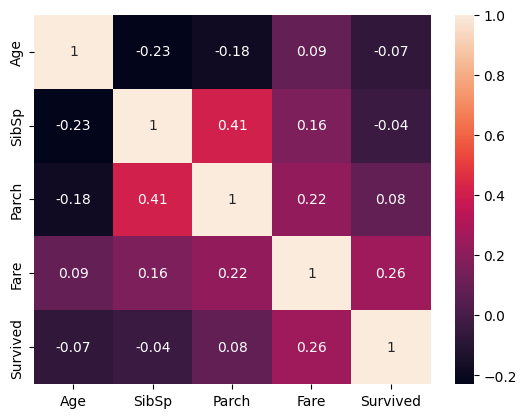

In [56]:
# plot of the correlation matrix
sns.heatmap(corr_matrix, annot=True)

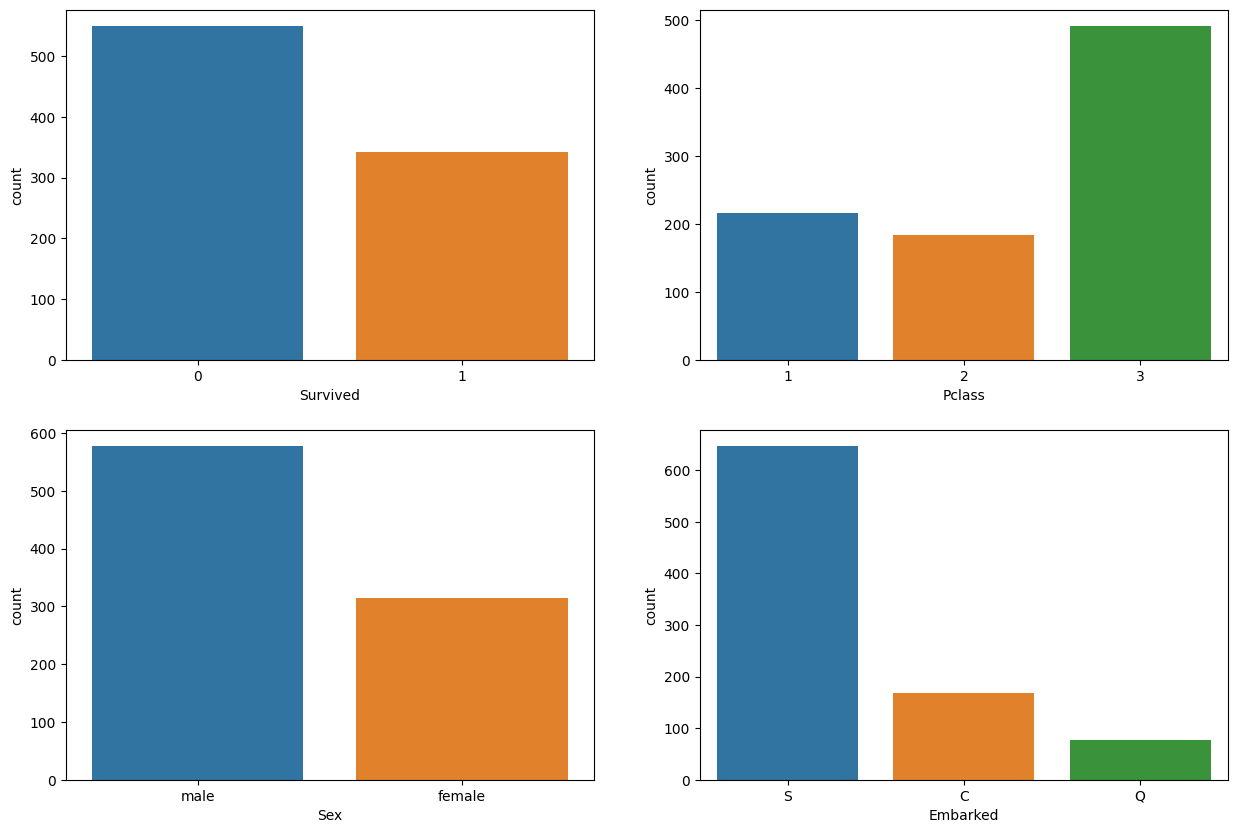

In [57]:
# plot categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(cat_df.columns):
    sns.countplot(x=col, data=cat_df, ax=axes[i // 2, i % 2])

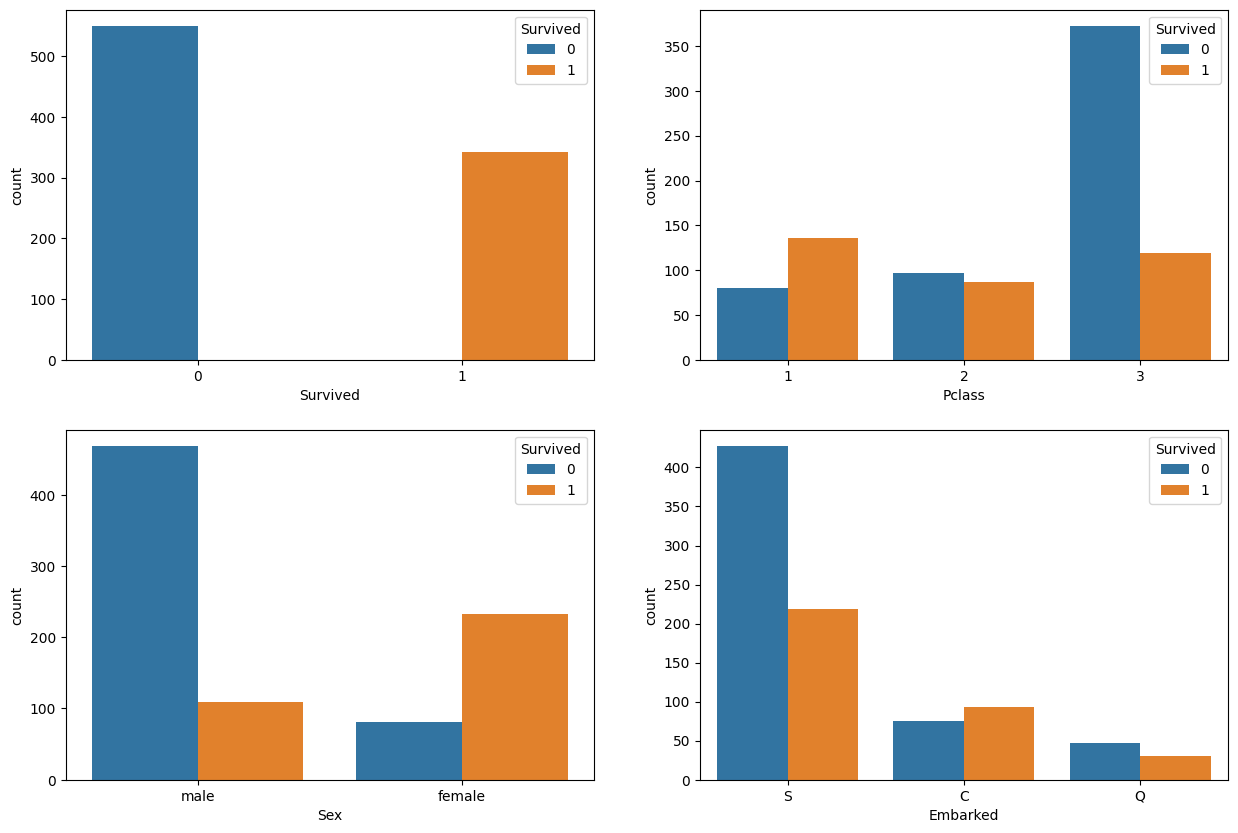

In [58]:
# plot categorical features again the survived column
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(cat_df.columns):
    sns.countplot(x=col, hue="Survived", data=cat_df, ax=axes[i // 2, i % 2])

We can see that the numerical feature with the highest correlation with the Survival rate is the Fare. Something that is interesting because the Fare is indicative of Pclass, which in turn is a good predictor of Survival rate. Additionally, Gender and Embarked port also appear to be strong indicators of survivorship.

## Feature selection

In [59]:
# trainig data
X_train = train_df.drop(["PassengerId", "Survived", "Name", "SibSp", "Parch"], axis=1)

In [60]:
# encode categorical features
X_train = pd.get_dummies(X_train)
X_train.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,3,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,3,35.0,8.0500,False,True,False,False,True


In [61]:
# test data
X_test = test_df.drop(["PassengerId", "Name", "SibSp", "Parch"], axis=1)
X_test = pd.get_dummies(X_test)
X_test.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,7.8292,False,True,False,True,False
1,3,47.0,7.0000,True,False,False,False,True
2,2,62.0,9.6875,False,True,False,True,False
3,3,27.0,8.6625,False,True,False,False,True
4,3,22.0,12.2875,True,False,False,False,True


In [62]:
# nan values in the test data
X_test.isna().sum()

Pclass        0
Age           0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [63]:
# target data
y = train_df["Survived"]

## Model training

I decided to use a Random Forest classifier for this problem. I tried a few other models but the Random Forest classifier gave the best results.

In [64]:
# random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores = cross_val_score(rf_classifier, X_train, y, cv=10, scoring="accuracy")

print(round(scores.mean(), 2))

0.82


In [65]:
rf_classifier.fit(X_train, y)
predictions_rf = rf_classifier.predict(X_test)

## Exporting the results

In [66]:
# submission dataframe
submission_df = pd.DataFrame(
    {"PassengerId": test_df["PassengerId"], "Survived": predictions_rf}
)

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [67]:
# save the submission dataframe to a csv file
submission_df.to_csv("submission.csv", index=False)